In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('fer2013.csv')

# Preprocess the data
def preprocess_data(data):
    # Convert the pixels column to numpy arrays
    data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
    # Normalize the pixel values
    data['pixels'] = data['pixels'].apply(lambda x: x / 255.0)
    # Reshape the pixel values to 48x48
    data['pixels'] = data['pixels'].apply(lambda x: x.reshape(48, 48, 1))
    return data

data = preprocess_data(data)

# Split the data into training and validation sets
train_data = data[data['Usage'] == 'Training']
val_data = data[data['Usage'] == 'PublicTest']

# Extract features and labels
X_train = np.stack(train_data['pixels'].values)
y_train = tf.keras.utils.to_categorical(train_data['emotion'], num_classes=7)

X_val = np.stack(val_data['pixels'].values)
y_val = tf.keras.utils.to_categorical(val_data['emotion'], num_classes=7)

# Resize images to 96x96 to match EfficientNetB0 input size
X_train = tf.image.resize(X_train, [96, 96])
X_val = tf.image.resize(X_val, [96, 96])

# Convert grayscale images to RGB by duplicating the single channel three times
X_train = tf.image.grayscale_to_rgb(X_train)
X_val = tf.image.grayscale_to_rgb(X_val)

In [2]:
# Define the number of classes
num_classes = 7  # Update this to match your dataset
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(96,96, 3))


# Modify the model to match the number of classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint('IncepV3Fer2013.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=75,
    batch_size=64,
    callbacks=[checkpoint]
)

Epoch 1/75
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.1841 - loss: 13.6208
Epoch 1: val_accuracy improved from -inf to 0.34299, saving model to IncepV3Fer2013.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 501s 971ms/step - accuracy: 0.1842 - loss: 13.6174 - val_accuracy: 0.3430 - val_loss: 9.2957
Epoch 2/75
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.3819 - loss: 8.1644
Epoch 2: val_accuracy improved from 0.34299 to 0.48036, saving model to IncepV3Fer2013.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 429s 955ms/step - accuracy: 0.3820 - loss: 8.1623 - val_accuracy: 0.4804 - val_loss: 5.4815
Epoch 3/75
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.4905 - loss: 4.8541
Epoch 3: val_accuracy improved from 0.48036 to 0.51574, saving model to IncepV3Fer2013.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 420s 936ms/step - accuracy: 0.4905 - loss: 4.8529 - val_accuracy: 0.5157 - val_loss: 3.4444
Epoch 4/75
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.5753 - loss: 3.0027
Epoch 4

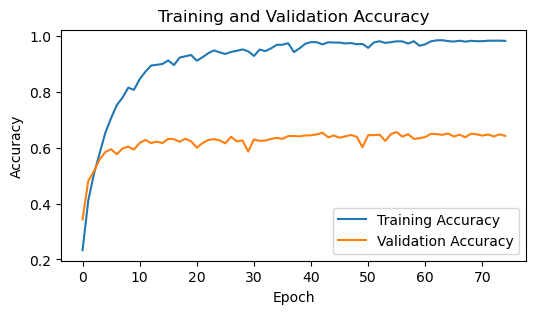

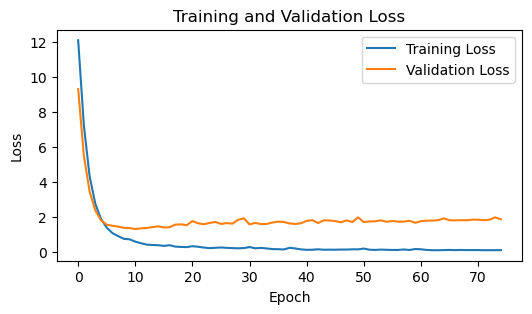

In [4]:
# Plotting Training and Validation Accuracy
f, ax = plt.subplots(figsize=(6, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
f, ax = plt.subplots(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step
Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.55      0.55       467
     disgust       0.68      0.54      0.60        56
        fear       0.53      0.51      0.52       496
       happy       0.84      0.84      0.84       895
         sad       0.53      0.59      0.56       653
    surprise       0.77      0.80      0.79       415
     neutral       0.63      0.57      0.60       607

    accuracy                           0.66      3589
   macro avg       0.65      0.63      0.64      3589
weighted avg       0.66      0.66      0.66      3589



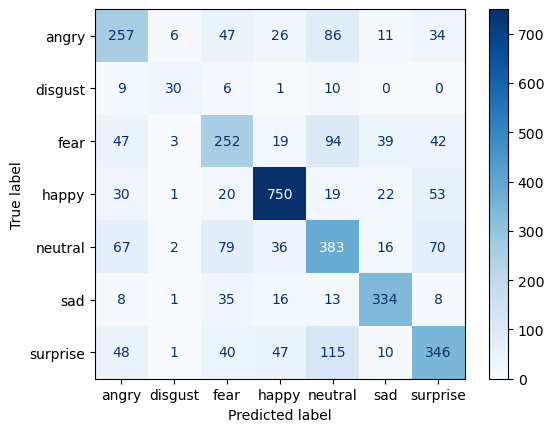

In [5]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
model =tf.keras.models.load_model('IncepV3Fer2013.keras')
# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Generate the classification report
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm

labels=['angry','disgust','fear','happy','neutral','sad','surprise']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Emotion: happy


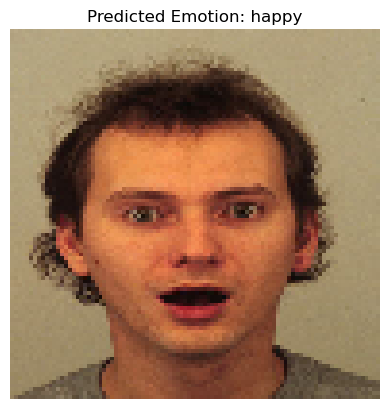

In [6]:
# Ensure you have matplotlib installed, otherwise install it using pip
# pip install matplotlib

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(image_path, target_size=(96,96)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array  # Return both the PIL image and the preprocessed array

# Now you can use the preprocess_image function
original_img, img_array = preprocess_image('12_21.jpg')
prediction = model.predict(img_array)

# Get the index of the highest probability in the prediction
predicted_index = np.argmax(prediction)

# Assuming you have a list of class labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Example labels

# Map the predicted index to the corresponding label
predicted_label = class_labels[predicted_index]

# Print the predicted label as a string
print(f"Predicted Emotion: {predicted_label}")

# Display the image using matplotlib
plt.imshow(original_img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Emotion: happy


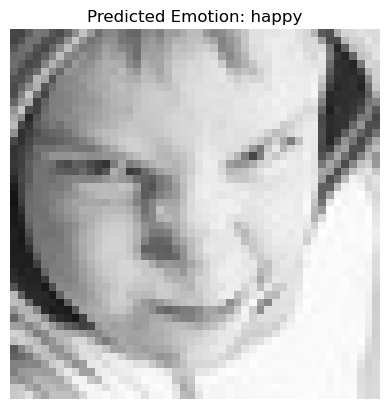

In [7]:
# Ensure you have matplotlib installed, otherwise install it using pip
# pip install matplotlib

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(image_path, target_size=(96,96)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array  # Return both the PIL image and the preprocessed array

# Now you can use the preprocess_image function
original_img, img_array = preprocess_image('PrivateTest_20588149.jpg')
prediction = model.predict(img_array)

# Get the index of the highest probability in the prediction
predicted_index = np.argmax(prediction)

# Assuming you have a list of class labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Example labels

# Map the predicted index to the corresponding label
predicted_label = class_labels[predicted_index]

# Print the predicted label as a string
print(f"Predicted Emotion: {predicted_label}")

# Display the image using matplotlib
plt.imshow(original_img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot